# FIGURE 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing
from msresist.figures.figure1 import plotClustergram, plotVarReplicates, plotReplicatesEndpoint, plotAveragedEndpoint, plotReplicatesFoldChangeEndpoint, plotVarReplicates
import warnings
warnings.simplefilter("ignore")

## 1. Phosphorylation Measurements

Hierarchical Clustering of pre-processed data:

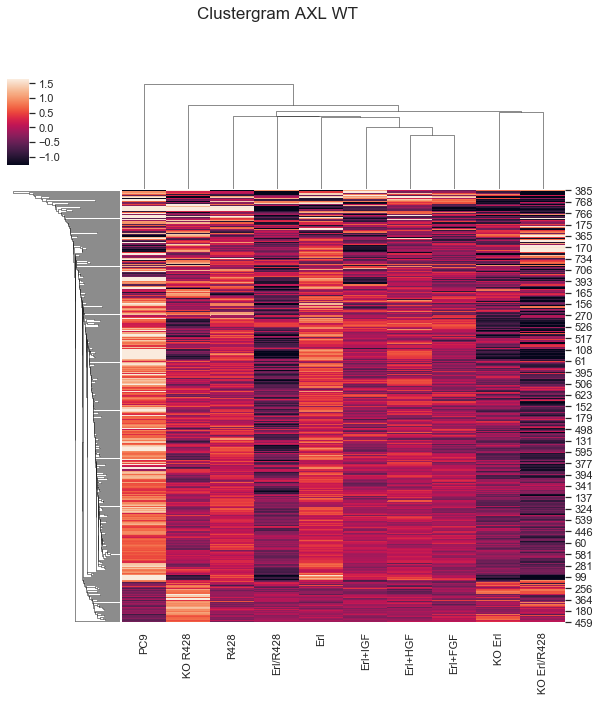

In [2]:
ABC = preprocessing(AXLwt=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True)
plotClustergram(ABC, "Clustergram AXL WT")

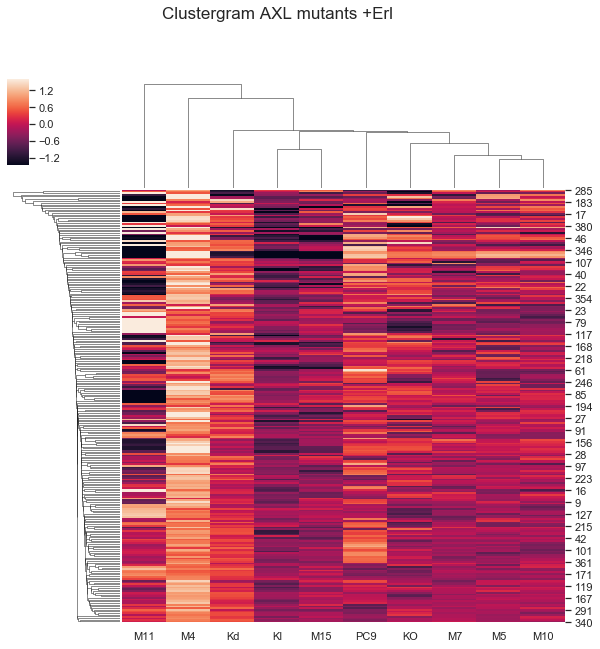

In [3]:
ABC = preprocessing(Axlmutants_Erl=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True)
plotClustergram(ABC, "Clustergram AXL mutants +Erl")

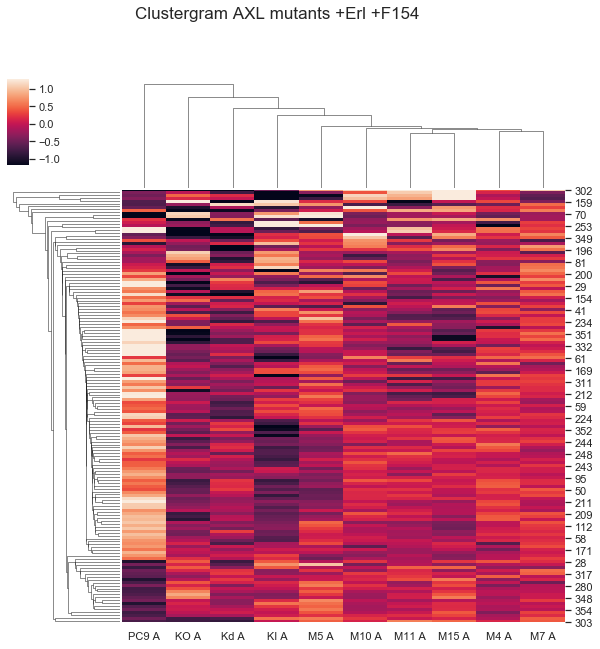

In [4]:
ABC = preprocessing(Axlmutants_Erl_F154=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True)
plotClustergram(ABC, "Clustergram AXL mutants +Erl +F154")

Variability of overlapping peptides across MS replicates. Pearson's correlation coefficient was computed for peptides overlapping across 2 MS replicates. For those overlapping 3 or more times, the Std was calculated.

,Protein,Sequence,UniprotAcc,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428
0,Alpha-enolase ; ENO1,aAVPSGASTGIyEALELR-1,P06733,0.380463,-0.252746,-0.099739,-0.081470,0.041829,-0.197131,0.266632,-0.079869,0.138428,-0.116398
1,Alpha-enolase ; ENO1,aAVPSGASTGIyEALELRDNDk-1,P06733,0.198171,-0.082829,-0.242864,-0.265561,-0.144468,0.138360,-0.005705,0.138107,0.210536,0.056253
2,Alpha-enolase ; ENO1,aAVPSGAStGIYEALELRDNDkTR-1,P06733,0.176992,0.059421,-0.222378,-0.075176,-0.188601,0.395127,-0.390902,0.137421,0.253186,-0.145090
3,40S ribosomal protein SA ; RPSA,aDHQPLTEASyVNLPTIALcNTDSPLR-1,P08865,-0.015025,-0.339290,-0.157915,0.010784,-0.158197,-0.170259,0.095367,0.032388,0.509027,0.193120
4,Plakophilin-3 ; PKP3,aDyDTLSLR-1,Q9Y446,-0.239880,-0.138663,-0.267024,0.692640,0.073958,0.124091,0.504876,-0.406650,0.096706,-0.440053
...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,Phospholysine phosphohistidine inorganic pyrop...,yYkETSGLMLDVGPYMk-1,Q9H008,-0.274972,-0.273158,-0.346907,-0.179804,-0.325051,-0.178889,-0.214571,0.417523,0.667829,0.708000
810,"GDP-mannose 4,6 dehydratase ; GMDS",yYRPTEVDFLQGDcTk-1,O60547,-0.093126,0.445548,0.220114,0.256040,0.167191,0.208491,0.135326,-0.328692,-0.101748,-0.909145
811,Proteasome subunit beta type-2 ; PSMB2,yYTPTISR-1,P49721,0.563728,0.245600,0.191139,-0.426883,0.318858,-0.108539,-0.106497,-0.228784,-0.069099,-0.379522
812,Heat shock protein HSP 90-alpha ; HSP90AA1,yYtSASGDEMVSLk-1,P07900,0.709517,0.450366,0.622201,0.063733,0.415062,-0.011376,-0.088310,-0.675655,-0.429257,-1.056281


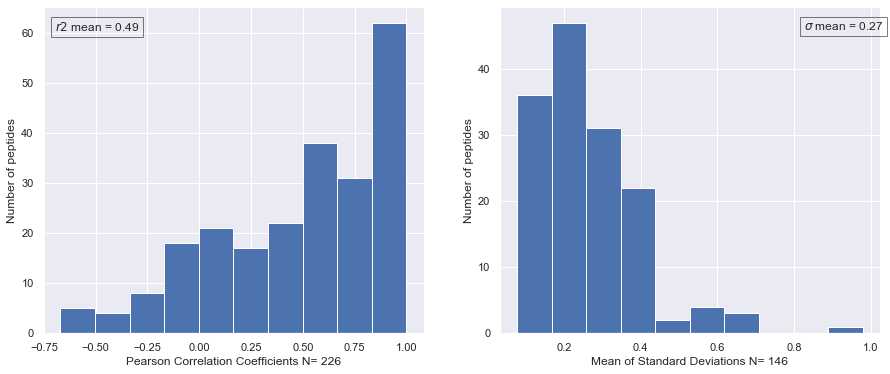

In [5]:
ABC = preprocessing(AXLwt=True, rawdata=True)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plotVarReplicates(ax, ABC)

## 2. Cell Viability Measurements:

Average between two replicates. Fold-change 72h vs 0h.

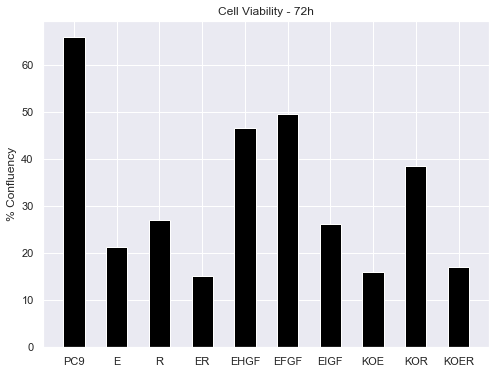

In [6]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotAveragedEndpoint(ax, Y_cv1, Y_cv2)

Raw Measurements of both replicates. Initial seeding was clearly off in Exp4.

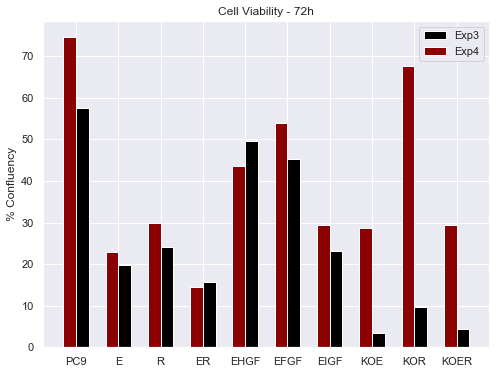

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotReplicatesEndpoint(ax, Y_cv1, Y_cv2)

However, by fold-changing to t=0h, both replicates are notably reproducible:

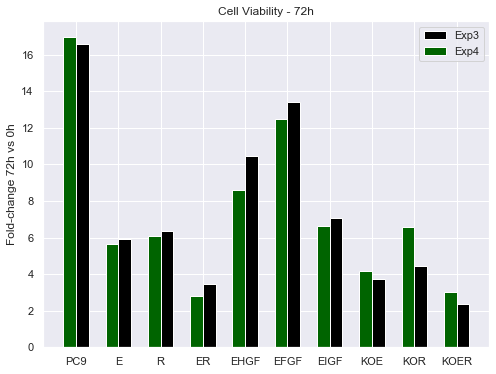

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotReplicatesFoldChangeEndpoint(ax, Y_cv1, Y_cv2)

## Cell Viability levels of RIPK1-Transfected PC9 cells

In [9]:
Time = pd.read_csv('./msresist/data/Phenotypic_data/RIPK1_CV_PC9_samples_raw_byRow.csv', delimiter='\t').iloc[:, 1]
full = pd.read_csv('./msresist/data/Phenotypic_data/RIPK1_CV_PC9_samples_raw_byRow.csv', delimiter='\t').iloc[:, 2:]

In [10]:
avg_full = np.zeros((20, 24))
for i in range(full.shape[0]):
    for j in range(int(full.shape[1]/3)):
        avg_full[i, j] = full.iloc[i, j*3:(j+1)*3].mean()
        
avg_full = pd.DataFrame(avg_full)

In [11]:
full = pd.concat([Time, avg_full], axis=1)
full.columns = ["Elapsed", ".8_wt+fbs", ".8_wt-fbs", ".8_YF+fbs", ".8_YF-fbs", 
                "1_wt+fbs", "1_wt-fbs", "1_YF+fbs", "1_YF-fbs",
                "1.3_wt+fbs", "1.3_wt-fbs","1.3_YF+fbs", "1.3_YF-fbs",
                "1.5_wt+fbs", "1.5_wt-fbs","1.5_YF+fbs", "1.5_YF-fbs",
                "2_wt+fbs", "2_wt-fbs","2_YF+fbs", "2_YF-fbs",
                "3_wt+fbs", "3_wt-fbs", "3_YF+fbs", "3_YF-fbs"]

full = full.set_index("Elapsed")

In [12]:
Xidx = [i for i in range(0,24,2)]
full = full.iloc[:, Xidx]

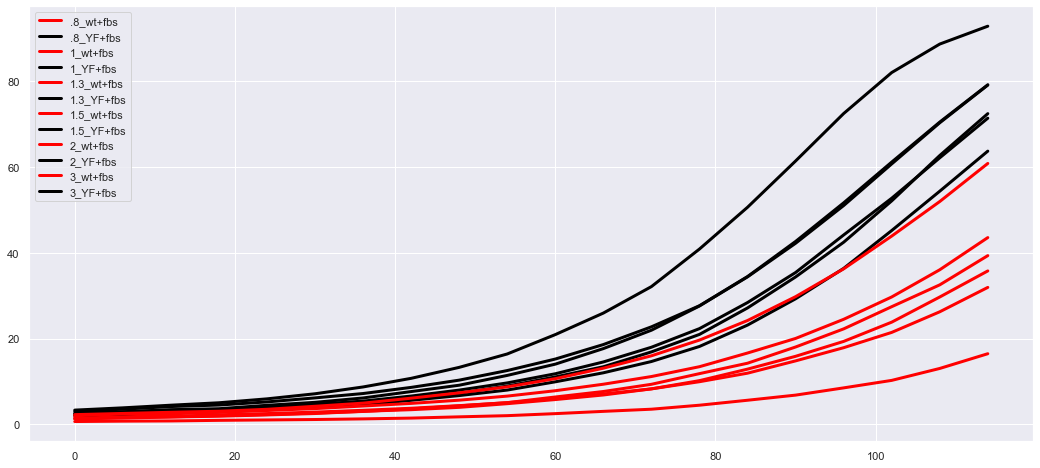

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))

for i in range(12):
    if i in [j for j in range(0, 12, 2)]:
        ax.plot(full.iloc[:, i], label=full.columns[i], linewidth=3, color="red")
    else:
        ax.plot(full.iloc[:, i], label=full.columns[i], linewidth=3, color="black")

ax.legend(loc=2);

In [14]:
full = full.reset_index()

In [15]:
import scipy as sp

Y_cv0 = full[full["Elapsed"] == 0].iloc[0, 1:]
Y_fc108 = full[full["Elapsed"] == 108].iloc[0, 1:] / Y_cv0

print(sp.stats.pearsonr(Y_cv0, Y_fc108)[1])
assert sp.stats.pearsonr(Y_cv0, Y_fc108)[1] > 0.05, "cell seeding effect"

for ii in range(1, full.columns.size):
    full.iloc[:, ii] /= full.iloc[0, ii]

0.14426943843606974


In [16]:
full = full.set_index("Elapsed")

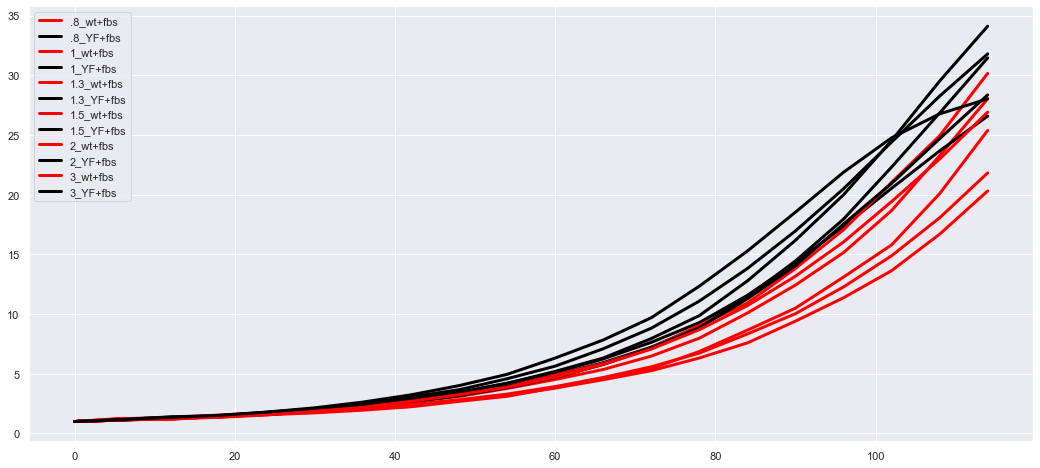

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))

for i in range(12):
    if i in [j for j in range(0, 12, 2)]:
        ax.plot(full.iloc[:, i], label=full.columns[i], linewidth=3, color="red")
    else:
        ax.plot(full.iloc[:, i], label=full.columns[i], linewidth=3, color="black")

ax.legend(loc=2)

In [18]:
full = full.reset_index()

Text(0, 0.5, 'fold-change confluency')

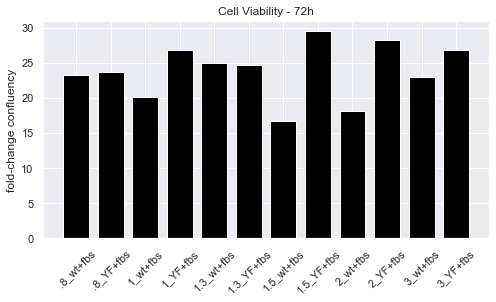

In [19]:
fig, ax = plt.subplots(1, figsize=(8,4))

range_ = np.linspace(1, 12, 12)

ax.set_title("Cell Viability - 72h")
ax.set_xticks(np.arange(1, 13, 1))
ax.set_xticklabels(full.columns[1:], rotation=45)
ax.bar(range_, full[full["Elapsed"] == 108].iloc[0, 1:], width=0.75, align='center', color="black")
ax.set_ylabel("fold-change confluency")